<a href="https://colab.research.google.com/github/arefafzali/Spiking_MNIST/blob/main/Spiking_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip3 install nengo
!pip3 install nengo_dl

     |████████████████████████████████| 523 kB 8.3 MB/s 
     |████████████████████████████████| 283 kB 9.5 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for nengo-dl: filename=nengo_dl-3.4.2-py3-none-any.whl size=204641 sha256=3d3316827bea6d61603a663959478a525b7f157566e84337f75a74f93c4a6860
  Stored in directory: /root/.cache/pip/wheels/07/22/9b/abf4313c8943df36addfec2336d2d6559c9f7a85f7bf0c67b2
Successfully built nengo-dl
  Attempting uninstall: progressbar2
    Found existing installation: progressbar2 3.38.0
    Uninstalling progressbar2-3.38.0:
      Successfully uninstalled progressbar2-3.38.0


In [2]:
%matplotlib inline

from urllib.request import urlretrieve
import nengo
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nengo_dl

11493376/11490434 [==============================] - 0s 0us/step


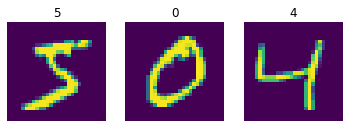

In [3]:
# importing data
(train_images, train_labels), \
  (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.imshow(train_images[i])
    plt.axis("off")
    plt.title(str(train_labels[i]))

In [4]:
# flatting images
train_images = train_images.reshape((train_images.shape[0], -1))
test_images = test_images.reshape((test_images.shape[0], -1))

In [5]:
train_images.shape

(60000, 784)

In [6]:
# preparing data to be able to process it in time
# add single timestep to training data
train_images = train_images[:, None, :]
train_labels = train_labels[:, None, None]

# when testing our network with spiking neurons we will need to run it
# over time, so we repeat the input/target data for a number of
# timesteps.
# n_steps = 30
n_steps = 10
test_images = np.tile(test_images[:, None, :], (1, n_steps, 1))
test_labels = np.tile(test_labels[:, None, None], (1, n_steps, 1))

In [7]:
train_images.shape

(60000, 1, 784)

In [8]:
# building network
with nengo.Network(seed=0) as net:
    net.config[nengo.Ensemble].max_rates = nengo.dists.Choice([100])
    net.config[nengo.Ensemble].intercepts = nengo.dists.Choice([0])
    net.config[nengo.Connection].synapse = None
    neuron_type = nengo.LIF(tau_rc=0.02, tau_ref=0.002, min_voltage=0, amplitude=0.01)
    # neuron_type = nengo.AdaptiveLIF(tau_n=1, inc_n=0.01, tau_rc=0.02, tau_ref=0.002, min_voltage=0, amplitude=0.01)
    nengo_dl.configure_settings(stateful=False)

    inp = nengo.Node(np.zeros(28 * 28))

    x = nengo_dl.Layer(tf.keras.layers.Conv2D(filters=64, strides=2, kernel_size=3))(
        inp, shape_in=(28, 28, 1)
    )
    x = nengo_dl.Layer(neuron_type)(x)

    x = nengo_dl.Layer(tf.keras.layers.Conv2D(filters=128, strides=2, kernel_size=3))(
        x, shape_in=(13, 13, 64)
    )
    x = nengo_dl.Layer(neuron_type)(x)

    # x = nengo_dl.Layer(tf.keras.layers.Conv2D(filters=32, kernel_size=3))(
    #     inp, shape_in=(28, 28, 1)
    # )
    # x = nengo_dl.Layer(neuron_type)(x)

    # x = nengo_dl.Layer(tf.keras.layers.Conv2D(filters=64, strides=2, kernel_size=3))(
    #     x, shape_in=(26, 26, 32)
    # )
    # x = nengo_dl.Layer(neuron_type)(x)

    # x = nengo_dl.Layer(tf.keras.layers.Conv2D(filters=128, strides=2, kernel_size=3))(
    #     x, shape_in=(12, 12, 64)
    # )
    # x = nengo_dl.Layer(neuron_type)(x)

    out = nengo_dl.Layer(tf.keras.layers.Dense(units=10))(x)

    # we'll create two different output probes, one with a filter
    # (for when we're simulating the network over time and
    # accumulating spikes), and one without (for when we're
    # training the network using a rate-based approximation)
    out_p = nengo.Probe(out, label="out_p")
    out_p_filt = nengo.Probe(out, synapse=0.1, label="out_p_filt")

In [9]:
# building Simulator
# minibatch_size = 200
minibatch_size = 50
sim = nengo_dl.Simulator(net, minibatch_size=minibatch_size)

Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:05                                               


In [10]:
# testing before training
def classification_accuracy(y_true, y_pred):
    return tf.metrics.sparse_categorical_accuracy(y_true[:, -1], y_pred[:, -1])


# note that we use `out_p_filt` when testing (to reduce the spike noise)
sim.compile(loss={out_p_filt: classification_accuracy})
print(
    "Accuracy:",
    sim.evaluate(test_images, {out_p_filt: test_labels}, verbose=0)["loss"],
)

Accuracy: 0.0869000032544136


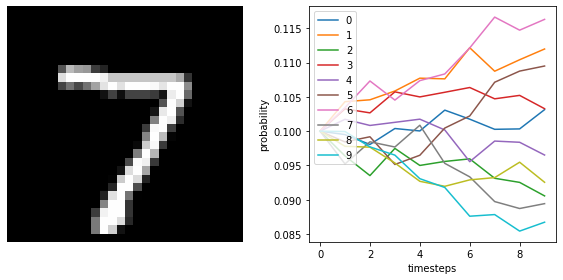

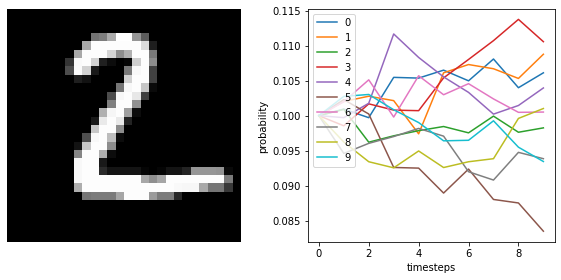

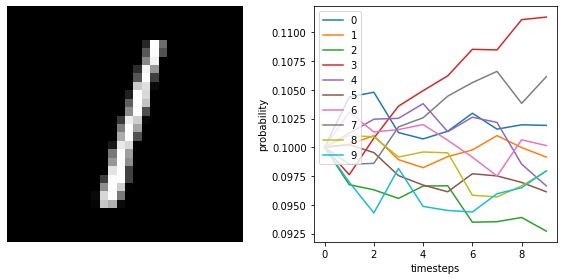

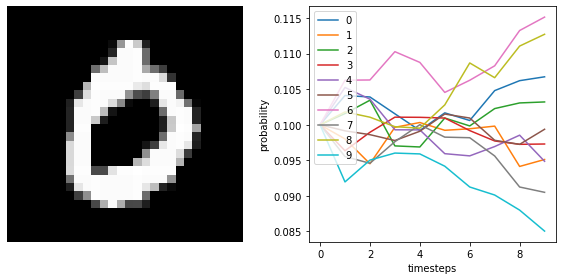

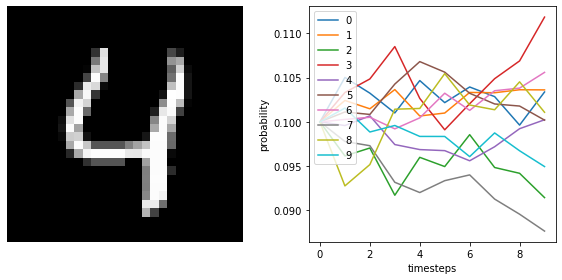

In [11]:
data = sim.predict(test_images[:minibatch_size])

for i in range(5):
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(test_images[i, 0].reshape((28, 28)), cmap="gray")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.plot(tf.nn.softmax(data[out_p_filt][i]))
    plt.legend([str(i) for i in range(10)], loc="upper left")
    plt.xlabel("timesteps")
    plt.ylabel("probability")
    plt.tight_layout()

In [12]:
# training
sim.compile(
    optimizer=tf.optimizers.RMSprop(0.001),
    loss={out_p: tf.losses.SparseCategoricalCrossentropy(from_logits=True)},
)
sim.fit(train_images, {out_p: train_labels}, epochs=10)

Epoch 1/10
1200/1200 [==============================] - 11s 6ms/step - loss: 0.1555 - out_p_loss: 0.1555
Epoch 2/10
1200/1200 [==============================] - 7s 6ms/step - loss: 0.0628 - out_p_loss: 0.0628
Epoch 3/10
1200/1200 [==============================] - 7s 6ms/step - loss: 0.0514 - out_p_loss: 0.0514
Epoch 4/10
1200/1200 [==============================] - 7s 6ms/step - loss: 0.0428 - out_p_loss: 0.0428
Epoch 5/10
1200/1200 [==============================] - 7s 6ms/step - loss: 0.0391 - out_p_loss: 0.0391
Epoch 6/10
1200/1200 [==============================] - 7s 6ms/step - loss: 0.0362 - out_p_loss: 0.0362
Epoch 7/10
1200/1200 [==============================] - 7s 6ms/step - loss: 0.0341 - out_p_loss: 0.0341
Epoch 8/10
1200/1200 [==============================] - 7s 6ms/step - loss: 0.0306 - out_p_loss: 0.0306
Epoch 9/10
1200/1200 [==============================] - 7s 6ms/step - loss: 0.0297 - out_p_loss: 0.0297
Epoch 10/10
1200/1200 [==============================] - 7s 6ms

In [13]:
# testing after training
sim.compile(loss={out_p_filt: classification_accuracy})
print(
    "Accuracy:",
    sim.evaluate(test_images, {out_p_filt: test_labels}, verbose=0)["loss"],
)

Accuracy: 0.9746999740600586


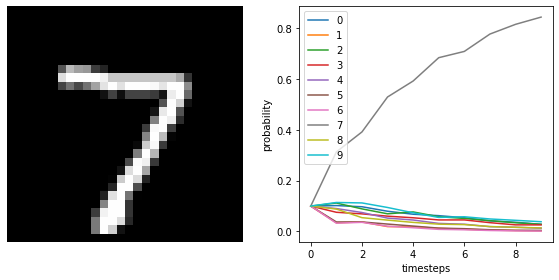

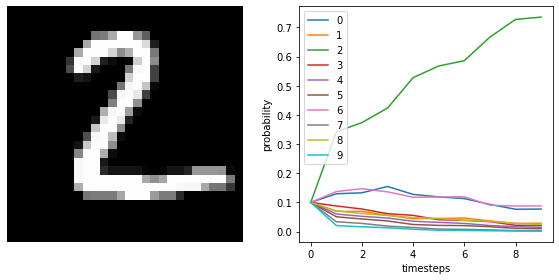

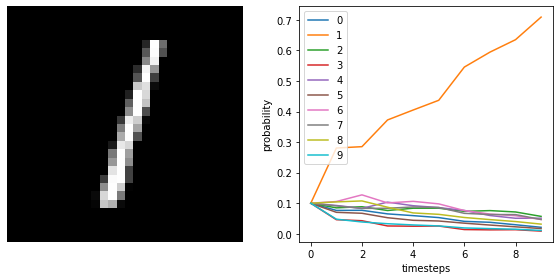

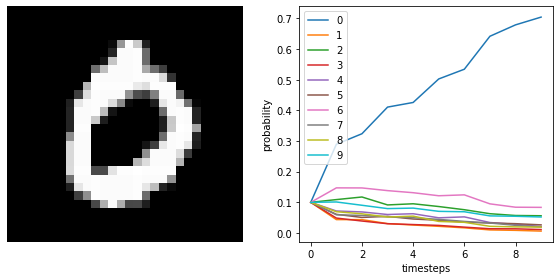

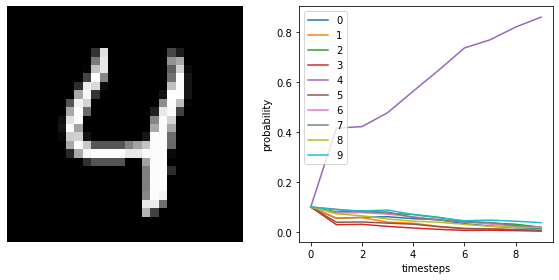

In [14]:
data = sim.predict(test_images[:minibatch_size])

for i in range(5):
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(test_images[i, 0].reshape((28, 28)), cmap="gray")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.plot(tf.nn.softmax(data[out_p_filt][i]))
    plt.legend([str(i) for i in range(10)], loc="upper left")
    plt.xlabel("timesteps")
    plt.ylabel("probability")
    plt.tight_layout()

In [15]:
sim.close()